# SM01: SageMaker and Production Pipelines

There are a lot of considerations in moving from a local model used to train and predict on batch data to a production model. This series of posts explores how to create an MLOps compliant production pipeline using AWS's SageMaker Studio.

SageMaker Studio is a suite of tools that helps manage the infrastructure and collaboration for a machine learning project in the AWS ecosystem. Some of the biggest advantages of SageMaker Studio include:

- Ability to spin up hardware resources as needed
- Automatically spin down hardware resources once the task is complete
- Ability to create a pipeline to automate the machine learning process from preprocessing data through deploying the model

This first post in the series will go over how to pull data from S3 and obtain file metadata. All outputs should match what is in the Notebook unless otherwise specified.

## Prerequisites

For brevity, I'll assume that SageMaker Studio and an IAM role with the appropriate permissions have been set up. In a corporate/enterprise environment, these will generally be set up by an administrator or someone on the architecture team.

- For directions on setting up the SageMaker environment see [Onboard to Amazon SageMaker Domain Using Quick setup](https://docs.aws.amazon.com/sagemaker/latest/dg/onboard-quick-start.html)
- For directions on setting up an AWS account and IAM role see [Set Up Amazon SageMaker Prerequisites](https://docs.aws.amazon.com/sagemaker/latest/dg/gs-set-up.html)

This notebook can be run Jupyter Notebook in SageMaker Studio or as a stand alone SageMaker Jupyter Notebook instance. It *may* work in a local environment where the AWS credentials are specified, but that use case hasn't been tried or tested. This series is designed to take advantage of the managed infrastructure and other benefits of using SageMaker Studio, so that will be the prefered environment for all posts in the series.

## Write data to S3

*Note*, if you already have data in an S3 bucket, you can skip this step. However, the rest of the code in this post, as well as the rest of the series, uses the data saved to the default S3 bucket in this step.

The first part of any data science project is to get data. In working with AWS and SageMaker, the best practices choice for data storage is S3. S3 is the default for SageMaker inputs and outputs, including things like training data sets and model artifacts.

First, let's put some data into S3. The below cell reads in four files from the [Insurance Company Benchmark Data Set](https://archive.ics.uci.edu/ml/datasets/Insurance+Company+Benchmark+%28COIL+2000%29) hosted on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php).

I chose this data set for two main reasons:

- The features represent both textual/categorical and numeric data types
- Multile files are used to store the data

It is common to have to clean data prior to training. This process can easily start with data in multiple files that need to go through an ETL (extract, transform, load) process before a final single file is produced.

### Read in Data from UCI Repo

First we need to pull in our sample data from the UCI Machine Learning Repository. We can do this with `pandas`. Like many data scientists `pandas` is my go to library for data import/export, storage, and wrangling.

The `pandas` library now utilizes functionality from the `s3fs` library, which allows you to work with S3 files the same way you would with files on the local machine. *Note*, `s3fs` needs to be installed on the machine you're working on, but it does *not* need to be imported into the notebook. In my experience it's installed by default in SageMaker notebooks.

In [2]:
import pandas as pd

train_uri = 'https://archive.ics.uci.edu/ml/machine-learning-databases/tic-mld/ticdata2000.txt'
test_uri = 'https://archive.ics.uci.edu/ml/machine-learning-databases/tic-mld/ticeval2000.txt'
gt_uri = 'https://archive.ics.uci.edu/ml/machine-learning-databases/tic-mld/tictgts2000.txt'
cols_uri = 'https://archive.ics.uci.edu/ml/machine-learning-databases/tic-mld/dictionary.txt'

train = pd.read_table(train_uri, header=None)
test = pd.read_table(test_uri, header=None)
ground_truth = pd.read_table(gt_uri, header=None)
columns = pd.read_table(cols_uri, encoding='latin-1')
train.head()

,0,1,2,3,4,5,6,7,8,9,...,76,77,78,79,80,81,82,83,84,85
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,0


### Set AWS variables

There are several variables you'll need when sending information back and forth across the AWS infrastructure. These are generally permission/access type variables. It's also useful to capture frequently used information like the bucket and prefix to the specific folder you'll be reading and writing to. This also makes it easier to change the folder path should you want to use a different base location.

### import sagemaker.session

session = sagemaker.session.Session()
region = session.boto_region_name
role = sagemaker.get_execution_role()
bucket = session.default_bucket()
prefix = 'ins_dataset'

### Write to S3

Just like with reading in data, you can write data back to S3 using `pandas` per your usual workflow.

In [4]:
train.to_csv(f's3://{bucket}/{prefix}/raw/train.csv', index=False)
test.to_csv(f's3://{bucket}/{prefix}/raw/test.csv', index=False)
ground_truth.to_csv(f's3://{bucket}/{prefix}/raw/gt.csv', index=False)
columns.to_csv(f's3://{bucket}/{prefix}/raw/metadata/col_info.csv', index=False)

To see your data in AWS, simply print the `bucket` and `prefix` name and visit that folder in the AWS console.

In [ ]:
f'{bucket}/{prefix}'

The acutal output has been removed for security purposes. Here is an example of what the output should look like:

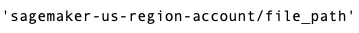

## Set Library Dependencies

Frequently, the library version doesn't match the version needed to run your code. The below cell demonstrates how to load packages as well as upgrade the versions. One of the most frequent library mismatches that I've run into recently is `pandas`. The default was `pandas 1.0.X` at the time this post was created. My code generally requires the updates from `pandas 1.3.5` or later.

The `pandas` version you see will probably be different than the one listed in the below output. The second cell below is the code to install or upgrade packages. The third cell is included to double check that the changes you want have been appropriately applied. *Note*, the code for this particular notebook should run on just about any `pandas` version >= 1.X.

In [5]:
pd.__version__

'1.3.5'

The below two cells are optional. This code was included as an example of how to update library dependencies.

In [6]:
import sys
!{sys.executable} -m pip install category_encoders
!{sys.executable} -m pip install pandas numpy --upgrade


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip


In [7]:
pd.__version__

'1.3.5'

## Read from S3

Now we get to the main point of this post. Reading in files and metadata from S3. First we need `numpy`, `pandas`, and `boto3`. `numpy` and `pandas` are packages for manipulating data, `boto3` facilitates interaction with AWS.

In [8]:
import numpy as np
import pandas as pd
import boto3

### Read a single file

Reading a single file is easy if you know the S3 URI.  Basically, we can do this the same way we initially read the file from the UCI Repo.

In [9]:
example = pd.read_csv(f's3://{bucket}/{prefix}/raw/train.csv')
example.head()

,0,1,2,3,4,5,6,7,8,9,...,76,77,78,79,80,81,82,83,84,85
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,0


# Read multiple files

Things get a little trickier when you need to read multiple files from a subdirectory.

## List files in subdirectory

You may or may not need to see what's in the folder. But I typically find it handy to be able to confirm what is or isn't there. There are several ways to do this:

- `boto3.client`
- `boto3.resource`
- command line

*Note*, all three of these methods return the name of the subdirectory as well as the files within it. The `boto3` methods both work with objects. For more on objects: 

- See [Resources](https://boto3.amazonaws.com/v1/documentation/api/latest/guide/resources.html) in the [Boto3 Docs Developer Guide](https://boto3.amazonaws.com/v1/documentation/api/latest/guide/index.html) for examples of working with Objects.
- See the [Object](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/s3.html#object) section of the [Boto3 Docs Available Services - S3](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/s3.html) for a full list of things that can be done with Objects. 

I'll look at these one by one. This is where having `bucket` and `prefix` variables comes in really handy. *Note*, no outputs are included for the cells that would reveal account specific information, including full S3 URIs. To see this information for yourself, please clone the repo and run the notebook.

#### boto3.client

In [ ]:
s3_client = boto3.client("s3")
s3_client.list_objects_v2(Bucket=bucket, Prefix=prefix)

The acutal output has been removed for security purposes. Here is an example of what the output should look like:

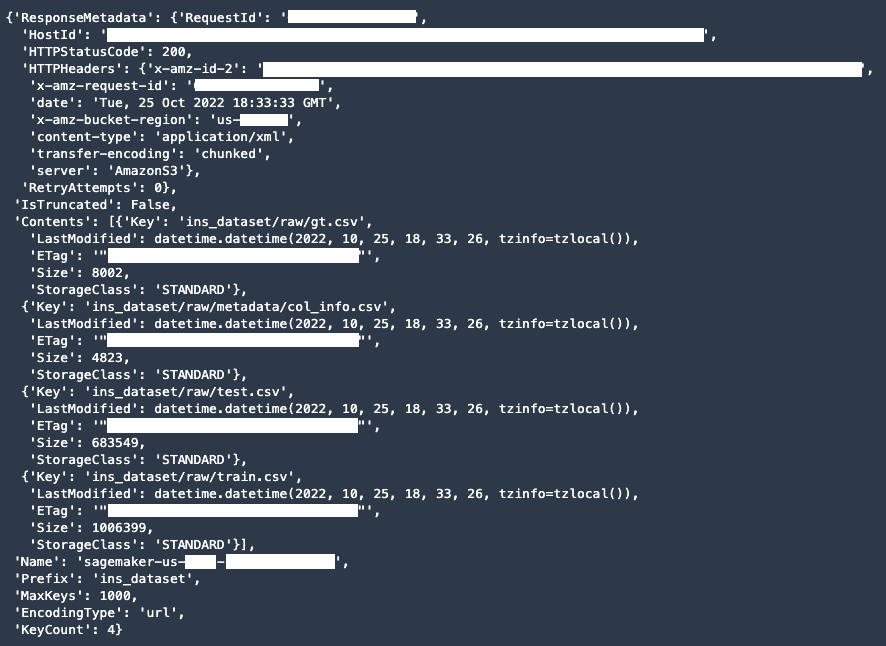

This is a lot of information and rather messy. We can narrow it down to just the information about the files by looking at the 'Contents'

In [ ]:
s3_client = boto3.client("s3")
s3_client.list_objects_v2(Bucket=bucket, Prefix=prefix)['Contents']

The acutal output has been removed for security purposes. Here is an example of what the output should look like:

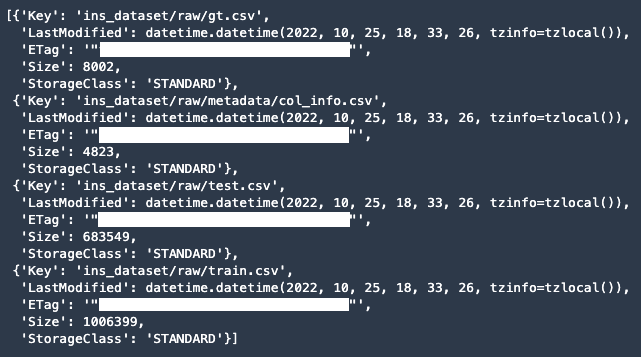

#### boto3.resource

In [12]:
s3_resource = boto3.resource("s3")
s3_bucket = s3_resource.Bucket(bucket)

for object_summary in s3_bucket.objects.filter(Prefix=prefix):
    print(object_summary.key)

ins_dataset/raw/gt.csv
ins_dataset/raw/metadata/col_info.csv
ins_dataset/raw/test.csv
ins_dataset/raw/train.csv


#### Comand line

In [ ]:
file_path = f's3://{bucket}/{prefix}/raw/'
file_path

The acutal output has been removed for security purposes. Here is an example of what the output should look like:



We then include the `file_path` variable in a bash command entered right into the Jupyter cell.

In [14]:
!aws s3 ls $file_path

                           PRE metadata/
2022-10-25 18:56:26       8002 gt.csv
2022-10-25 18:56:26     683549 test.csv
2022-10-25 18:56:25    1006399 train.csv


The size of the files (the middle values in the above output) can be useful for determining the amount of memory needed. I've also used it to chose smaller files for testing/prototyping code before spinning up larger instances to process larger files.

The information can be dumped into a csv file using the following code:

In [15]:
!aws s3 ls $file_path | cat >> files.csv

### Capture file names and read in

I find the `boto3.resource` output easiest to work with, so I'll use it to capture the file names and read in what I want.

In [16]:
s3_resource = boto3.resource("s3")
s3_bucket = s3_resource.Bucket(bucket)

file_names = []

for object_summary in s3_bucket.objects.filter(Prefix=prefix):
    if (len(object_summary.key.rsplit('.')) == 2):
        file_names.append(object_summary.key)
        
file_names

['ins_dataset/raw/gt.csv',
 'ins_dataset/raw/metadata/col_info.csv',
 'ins_dataset/raw/test.csv',
 'ins_dataset/raw/train.csv']

In the above snippet I split on `.` to ensure that the returned object is a file instead of a folder. Also note that this code goes into subdirectories and returns those files as well.

These kinds of conditionals can be used in many different ways to return only specific file types (csv vs parquet vs txt, etc) or to grab only portions of the file path. One use case for this would be a dictionary where the key is the file name and the value is the file path.

In [ ]:
s3_resource = boto3.resource("s3")
s3_bucket = s3_resource.Bucket(bucket)

files = {}

for object_summary in s3_bucket.objects.filter(Prefix=prefix):
    if (len(object_summary.key.rsplit('.')) == 2) & (len(object_summary.key.split('/')) <= 3):
        files[object_summary.key.split('/')[-1].split('.')[0]] = f"s3://{bucket}/{object_summary.key}"

files

The acutal output has been removed for security purposes. Here is an example of what the output should look like:

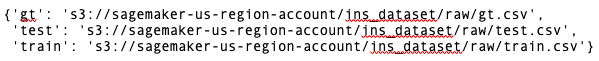

From the dictionary of 'name' and 'URI' it's easy to create a dictionary of dataframes.

The dictionary of dataframes data structure is extremely useful in that it's easy to name a dataframe and to have an unspecified number of dataframes to be read in.

In [18]:
df_dict = {}

for df_name in files.keys():
    print(df_name)
    df_dict[df_name] = pd.read_table(files[df_name], header=None)
    
df_dict

gt
test
train


{'gt':       0
 0     0
 1     0
 2     1
 3     0
 4     0
 ...  ..
 3996  0
 3997  1
 3998  0
 3999  0
 4000  0
 
 [4001 rows x 1 columns],
 'test':                                                       0
 0     0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18...
 1     33,1,4,2,8,0,6,0,3,5,0,4,1,1,8,2,2,6,0,0,1,2,6...
 2     6,1,3,2,2,0,5,0,4,5,2,2,1,4,5,5,4,0,5,0,0,4,0,...
 3     39,1,3,3,9,1,4,2,3,5,2,3,2,3,6,2,4,4,2,1,1,3,2...
 4     9,1,2,3,3,2,3,2,4,5,4,1,2,4,4,2,4,4,2,1,1,5,1,...
 ...                                                 ...
 3996  33,1,2,4,8,0,7,2,0,5,2,2,2,6,2,0,3,6,5,0,0,1,0...
 3997  24,1,2,3,5,1,5,1,3,4,2,4,4,4,2,2,4,4,2,0,0,3,3...
 3998  36,1,2,3,8,1,5,1,3,7,0,2,2,5,3,2,3,4,2,0,0,3,4...
 3999  33,1,3,3,8,1,4,2,3,7,1,2,2,3,4,1,3,5,1,1,1,2,3...
 4000  8,1,2,3,2,4,3,0,3,5,2,2,0,6,3,8,0,1,8,0,0,0,0,...
 
 [4001 rows x 1 columns],
 'train':                                                       0
 0     0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18...
 1     33,1,3,2

## Delete Files

To ensure no ongoing charges are charged to your account, you can delete the files from S3.

In [19]:
prefix = prefix + '/'

In [ ]:
s3_bucket = s3_resource.Bucket(bucket)
s3_bucket.objects.filter(Prefix=prefix).delete()

The acutal output has been removed for security purposes. Here is an example of what the output should look like:

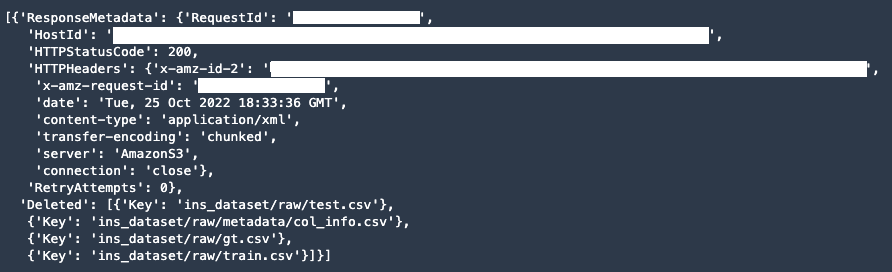

# Bonus

Some additional functionality. Downloading zipped files using 'wget' and uploading to S3 with the `sagemaker` module.

## Download and Unzip with `wget`

In [ ]:
!apt-get install unzip
!wget -N URL_to_zip_compressed_file.zip
# !wget -N https://sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com/autopilot/direct_marketing/bank-additional.zip
!unzip -o local_save_path.zip
# !unzip -o bank-additional.zip

local_data_path = "./local_save_path/downloaded_file_name.csv"
# local_data_path = "./bank-additional/bank-additional-full.csv"

## Upload to S3 with `sagemaker`

The benefits of using the `upload_data()` function are:

- s3_path is output back to the notebook
- the file type doesn't need to be specified in the function name (pandas requires different functions per file type: `to_csv`, `to_parquet`, etc)

In [ ]:
local_path = './local_path/upload_file_name.csv'
prefix = 'any_additional_dir_structure_you_want_beyond_the_bucket'

s3_path = session.upload_data(path=local_path, key_prefix=prefix)
print("Train data uploaded to: " + s3_path)